# Time series analysis using XGBoost

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
# OS
from pathlib import Path

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind')

# Warnings control
import warnings 
warnings.filterwarnings('ignore')

In [2]:
data_path = Path('data/PJME_hourly.csv')

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [5]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


# Data Cleaning

Steps undertaken:
- set index
- typecast
- outlier identification and removal

In [7]:
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

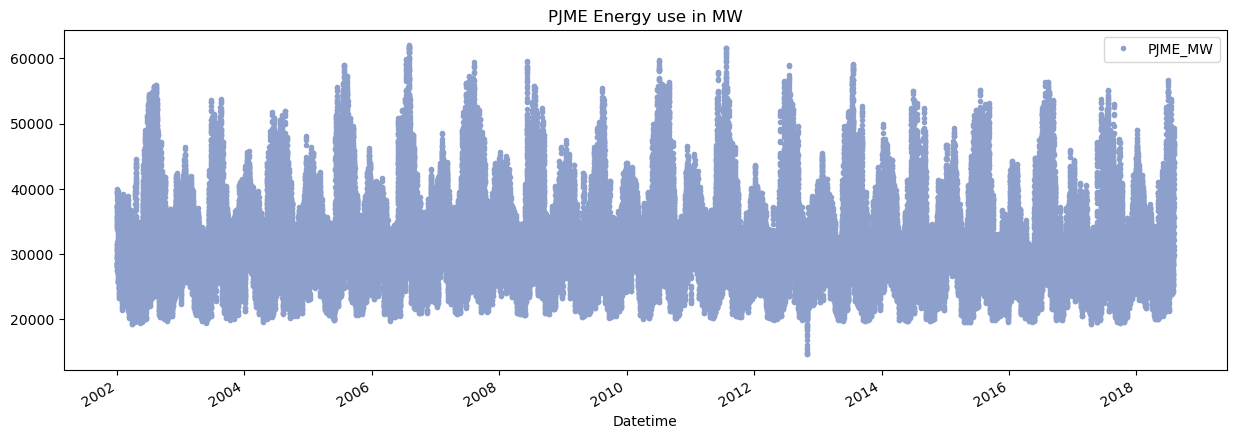

In [8]:
df.plot(title='PJME Energy use in MW',
        style='.',
        figsize=(15,5),
        use_index=True,
        color=color_pal[2])
plt.show()

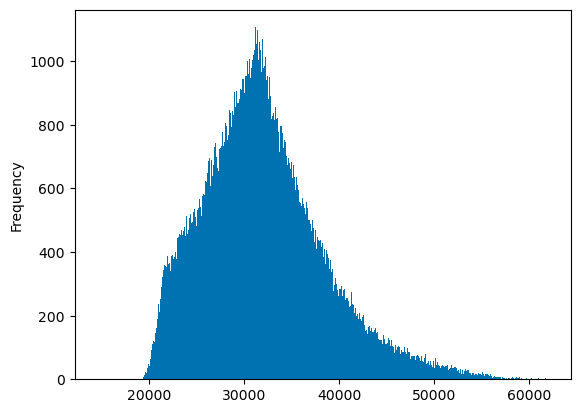

In [33]:
df['PJME_MW'].plot(kind='hist', bins=500);

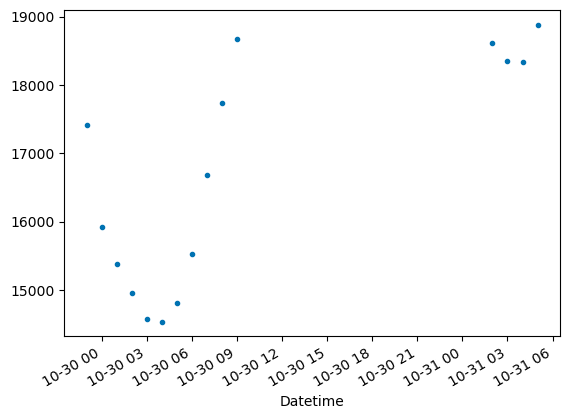

In [39]:
df.query('PJME_MW < 19000')['PJME_MW'].plot(style='.');

**Key Points**
- We see a bunch of values in october where the values dropped to a very low value that we can remove, as these data points are few and far between

In [40]:
df = df.query('PJME_MW > 19000').copy();

# Train Test Split

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

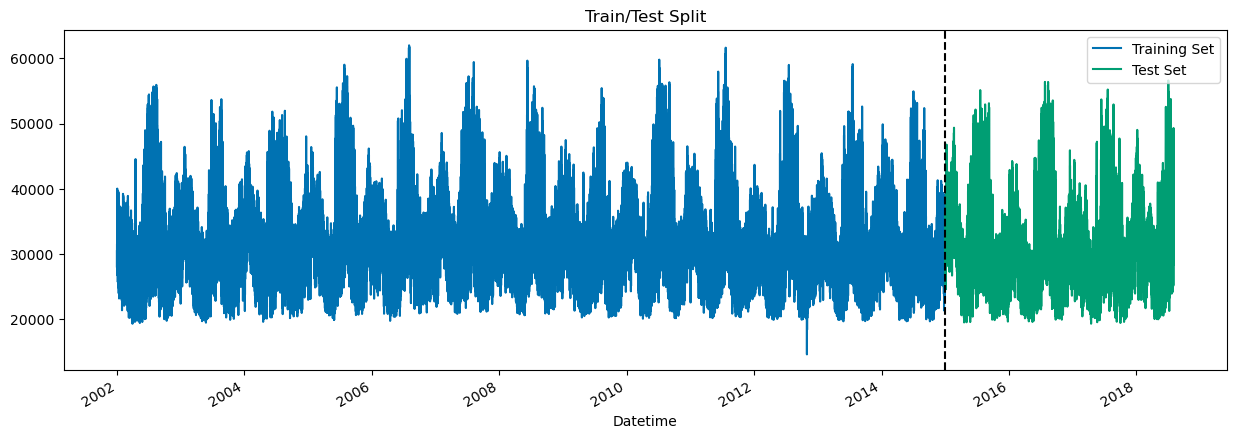

In [10]:
fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label='Train', title='Train/Test Split')
test.plot(ax=ax, label='Test')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

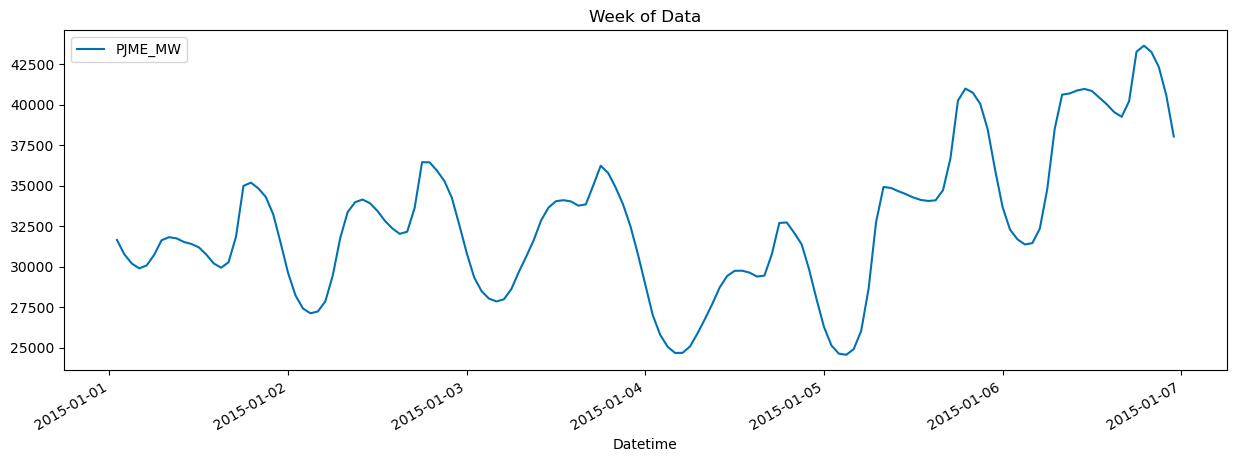

In [11]:
# visualising one week
df.loc[(df.index >'01-01-2015') & (df.index < '01-07-2015')] \
    .plot(figsize=(15,5), title='Week of Data') # note & denotes element-wise logical, whereas 'and' will ask python to typecast into bool

## Using Time Series Cross Validation

In [41]:
from sklearn.model_selection import TimeSeriesSplit

In [42]:
tss = TimeSeriesSplit(n_splits =5, test_size=24*365*1, gap=24)
df = df.sort_index()

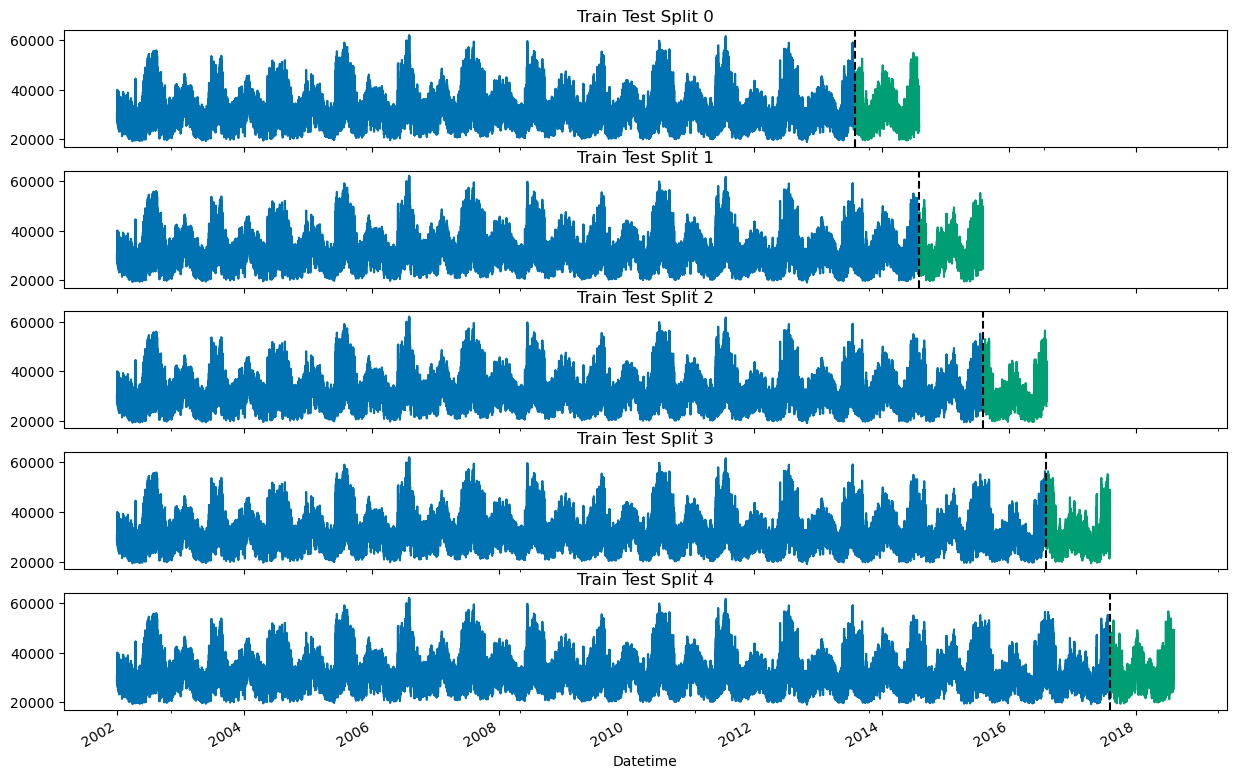

In [50]:
fig, axs = plt.subplots(5, 1, figsize=(15,10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax = axs[fold],
                          label='Training Set',
                          title = f'Train Test Split {fold}')
    test['PJME_MW'].plot(ax = axs[fold],
                          label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

We can see broadly how the train test splits are divided. We are testing each of the 5 years independently, one after another.

# Feature Creation

In [51]:
def create_features(df):
    """
    Create time series features given df with datetim index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [52]:
df = create_features(df)

## Lag features

- What was the target x days in the past

In [53]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) 
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

Note that we're using 364 days in the past because its divisible by 7. This ensures that the lag is on the same day, just a few years in the past.

In [55]:
df = add_lags(df)

In [56]:
df.tail(1)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2018-08-03,35486.0,0,4,3,8,2018,215,3,31,31588.259766,33539.0,32094.0,31695.0


# Visalising Feature / Target Relationship

In [14]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

Generating a heatmap of correlations, and the correlation with the target variable.

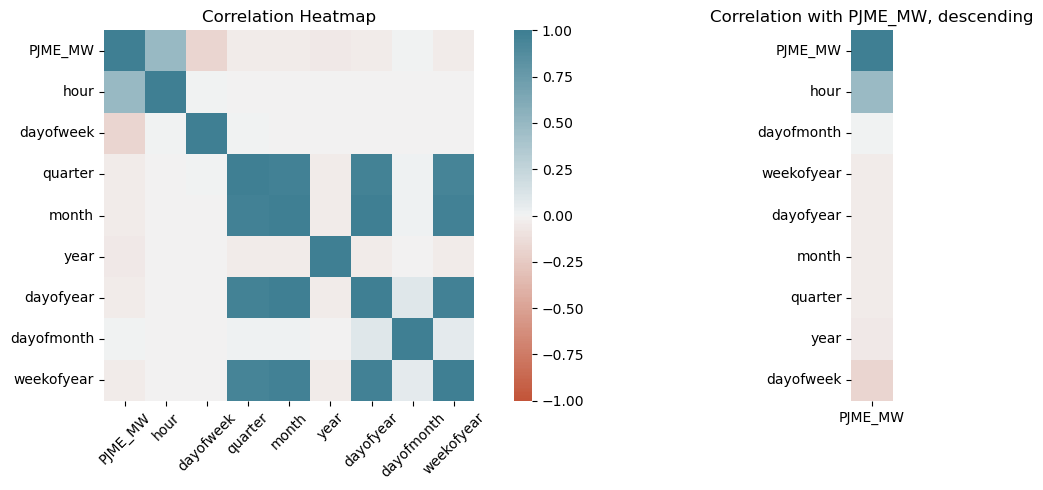

In [15]:
corr = df.corr() 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=-0.5, top=0.9, left=0.1)
ax1 = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), 
    square=True,
    ax = ax1
)
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    # horizontalalignment='right'
)
ax1.set_title('Correlation Heatmap')

# plotting correlation with target
corr_target = df.corr()[['PJME_MW']].sort_values(by=['PJME_MW'],ascending=False)
ax2 = sns.heatmap(corr_target,
                  vmin=-1, vmax=1, 
                  cmap=sns.diverging_palette(20, 220, n=200),
                  square=True,
                  cbar=False,
                  ax=ax2)
ax2.set_title('Correlation with PJME_MW, descending');
plt.tight_layout()

We can see that the most strongly correlated variable is hour, followed by day. Lets visualise this below:

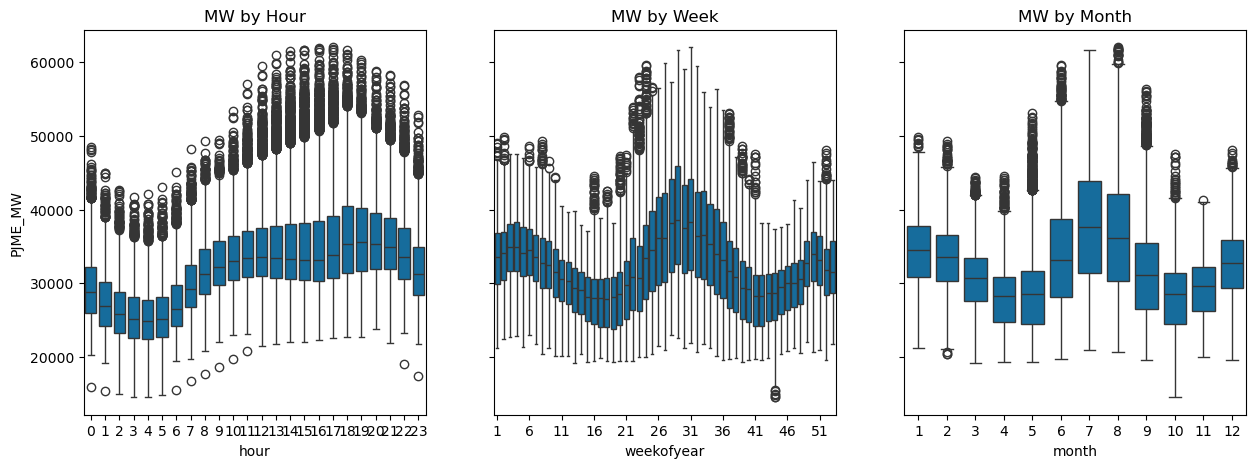

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
sns.boxplot(data=df, x='hour', y='PJME_MW', ax=ax1)
ax1.set_title('MW by Hour')

sns.boxplot(data=df, x='weekofyear', y='PJME_MW', ax=ax2)
ax2.set_title('MW by Week')
# Set ticks every 4 week
ax2.xaxis.set_major_locator(plt.MaxNLocator(12))

sns.boxplot(data=df, x='month', y='PJME_MW', ax=ax3)
ax3.set_title('MW by Month');

# Model Creation

In [17]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [18]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train), (X_test, y_test)],
        verbose=200)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/home/kyan/miniforge3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:46:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Training Using Cross Validation

In [63]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mse(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.29813	validation_1-rmse:31956.12901
[100]	validation_0-rmse:12532.43235	validation_1-rmse:11904.58782
[200]	validation_0-rmse:5744.95222	validation_1-rmse:5356.84300
[300]	validation_0-rmse:3871.90369	validation_1-rmse:3892.59716
[400]	validation_0-rmse:3435.02956	validation_1-rmse:3754.33238
[445]	validation_0-rmse:3365.94502	validation_1-rmse:3757.55814
[0]	validation_0-rmse:32671.76899	validation_1-rmse:32142.13679
[100]	validation_0-rmse:12513.53851	validation_1-rmse:12226.39459
[200]	validation_0-rmse:5755.01846	validation_1-rmse:5651.27874
[300]	validation_0-rmse:3906.82210	validation_1-rmse:3927.45255
[400]	validation_0-rmse:3478.17872	validation_1-rmse:3596.84442
[499]	validation_0-rmse:3353.70439	validation_1-rmse:3523.06106
[0]	validation_0-rmse:32630.97735	validation_1-rmse:31069.98153
[100]	validation_0-rmse:12498.81929	validation_1-rmse:11133.77575
[200]	validation_0-rmse:5749.69417	validation_1-rmse:4808.52984
[300]	validation_0-rmse:3914.33408

In [64]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3771.9760
Fold scores:[3753.6176552727843, 3523.0610618674414, 3473.313333085868, 4111.36839756937, 3998.5195052083054]


The average score is something that we are looking to improve upon

# Extracting Feature Importance

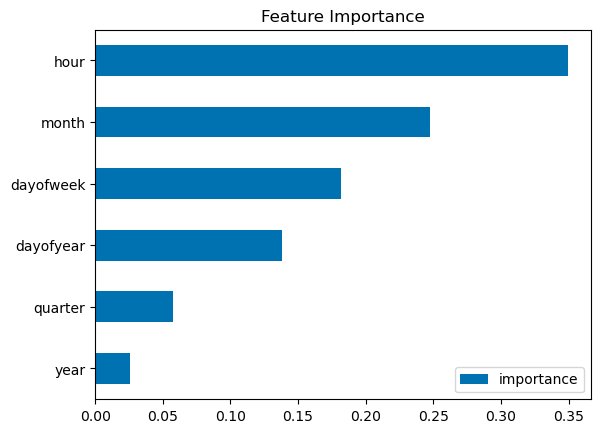

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecasting

In [20]:
# predict on test data
test['prediction'] = reg.predict(X_test)

In [21]:
# merging with the df and the test dataset
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

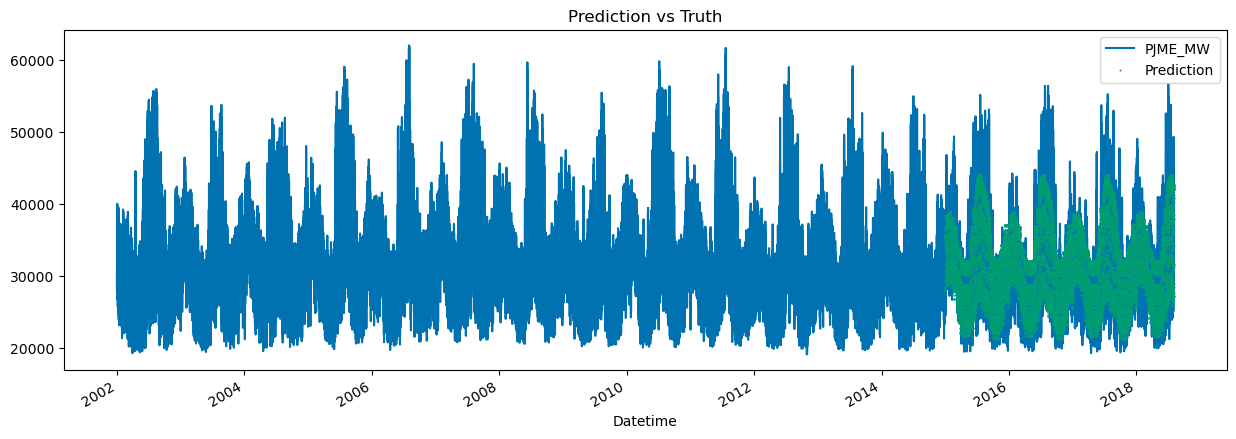

In [90]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.', label='Prediction', ms=1, lw=1)
plt.legend(loc="upper right")
ax.set_title('Prediction vs Truth');

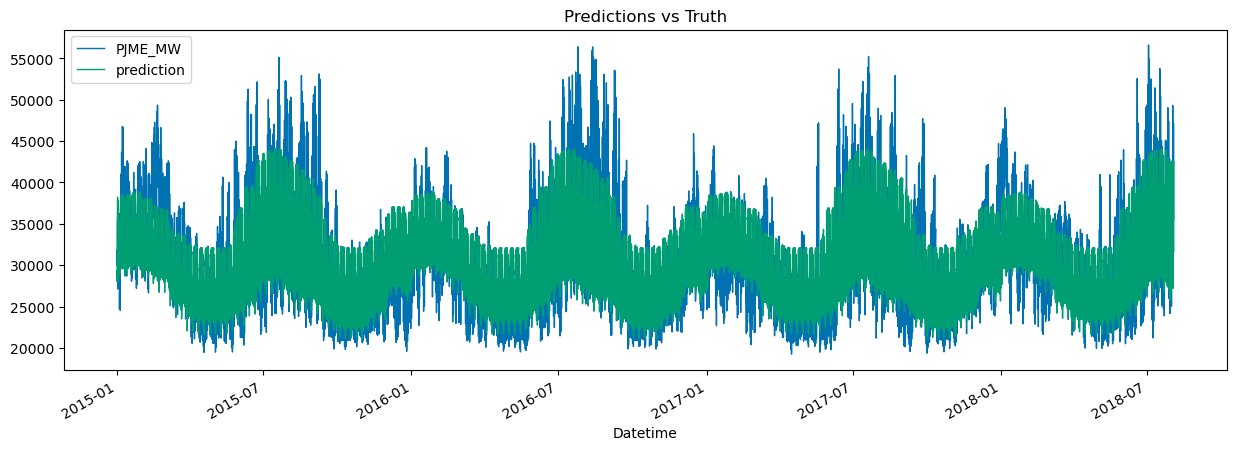

In [88]:
df.loc[(df.index >'01-01-2015')][['PJME_MW', 'prediction']] \
    .plot(figsize=(15,5), ms=1, lw=1, title='Predictions vs Truth');

Showcasing one weeks worth of data:

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

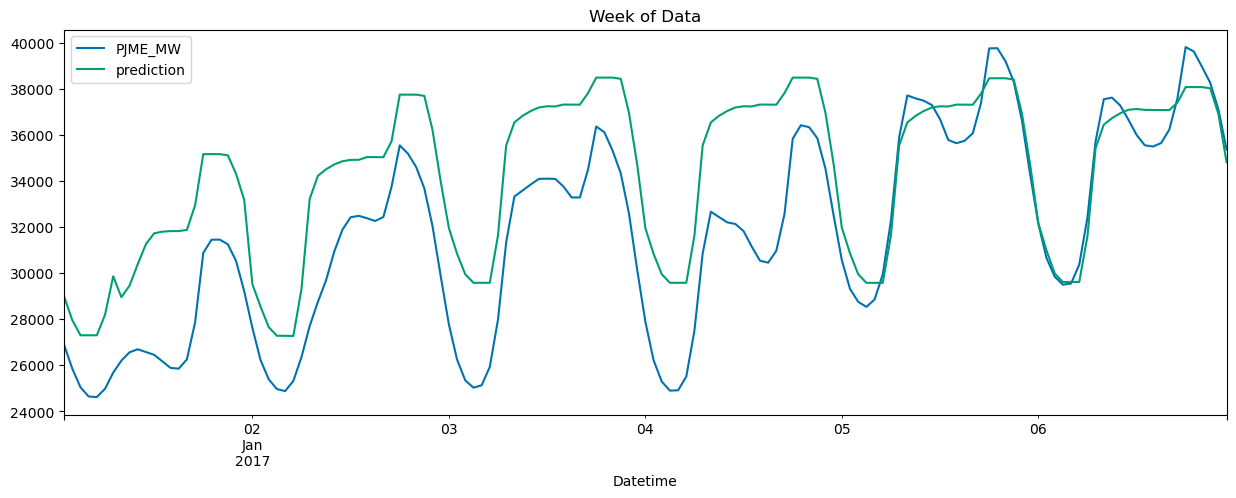

In [26]:
df.loc[(df.index >'01-01-2017') & (df.index < '01-07-2017')][['PJME_MW', 'prediction']] \
    .plot(figsize=(15,5), title='Week of Data') # note & denotes element-wise logical, whereas 'and' will ask python to typecast into bool

Notes:
- Models data quite well, up / down trends per day, including nighttime usage
- Does not model peaks / troughs well

Future improvements:
- Model days of year e.g. holidays
- Add more features
- more robust cross validation


# Model Analysis

Showcasing the best and worst performing results

In [27]:
score = np.sqrt(mse(test[TARGET], test['prediction']))
print(f'RMSE Score on test set: {score:.4f}')

RMSE Score on test set: 3726.7986


## Error calculation

In [28]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date

## Finding the best and worst performing days

Worst Performing Days:

In [29]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(3)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
Name: error, dtype: float64

Best performing days:

In [30]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(3)

date
2017-10-24    322.958008
2015-10-28    426.451335
2016-10-27    543.167155
Name: error, dtype: float64

The best performing days was in october 2017, and all best -performing days were in october. The worst performing days were in august 2016.

Lets visualise this:

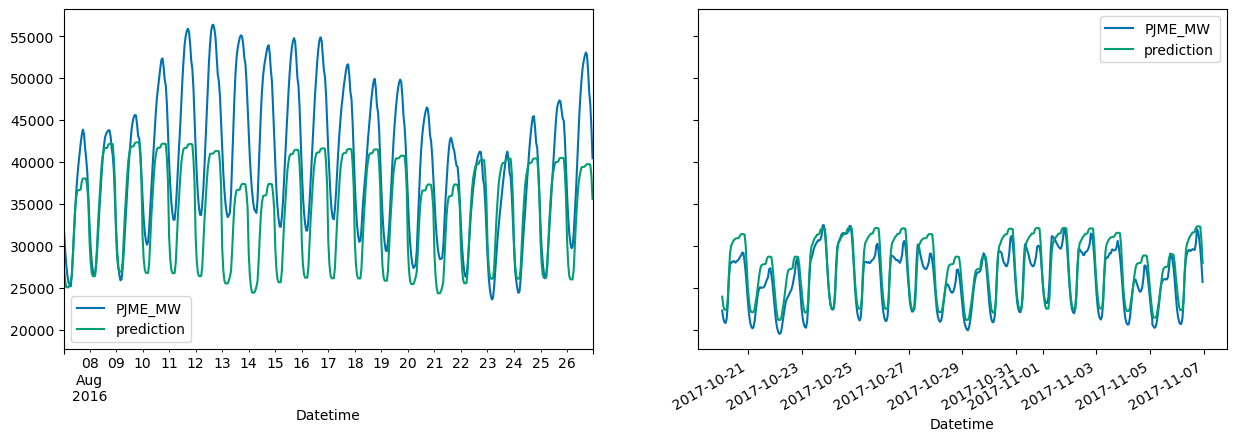

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
df.loc[(df.index >'08-07-2016') & (df.index < '08-27-2016')][['PJME_MW', 'prediction']].plot(ax=ax1)
df.loc[(df.index >'10-20-2017') & (df.index < '11-07-2017')][['PJME_MW', 'prediction']].plot(ax=ax2);

We can see that we consistently underpredicted for a period of time in august 2016, and some investigation is necessary to determine why that was the case. 

# Predicting the Future

Steps required:
- Train model on all the possible data
- create empty dataframe for future date ranges
- run the dates through the feature creation code + lag creation

In [65]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.50092
[100]	validation_0-rmse:12426.68377
[200]	validation_0-rmse:5752.98750
[300]	validation_0-rmse:3972.52175
[400]	validation_0-rmse:3572.64777
[499]	validation_0-rmse:3458.28412


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [66]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [70]:
# start from the last date in our training data
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_with_future = pd.concat([df, future_df])

In [71]:
df_with_future = create_features(df_with_future)
df_with_future = add_lags(df_with_future)

In [72]:
df_with_future.head(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,False


In [76]:
future_features = df_with_future.query('isFuture').copy()

In [77]:
future_features.tail(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3,isFuture
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,NaN,40666.0,34555.0,34641.0,True
2019-08-01 00:00:00,NaN,0,3,3,8,2019,213,1,31,NaN,37158.0,31646.0,31470.0,True


## Predicing the future

In [78]:
future_features['preds'] = reg.predict(future_features[FEATURES])

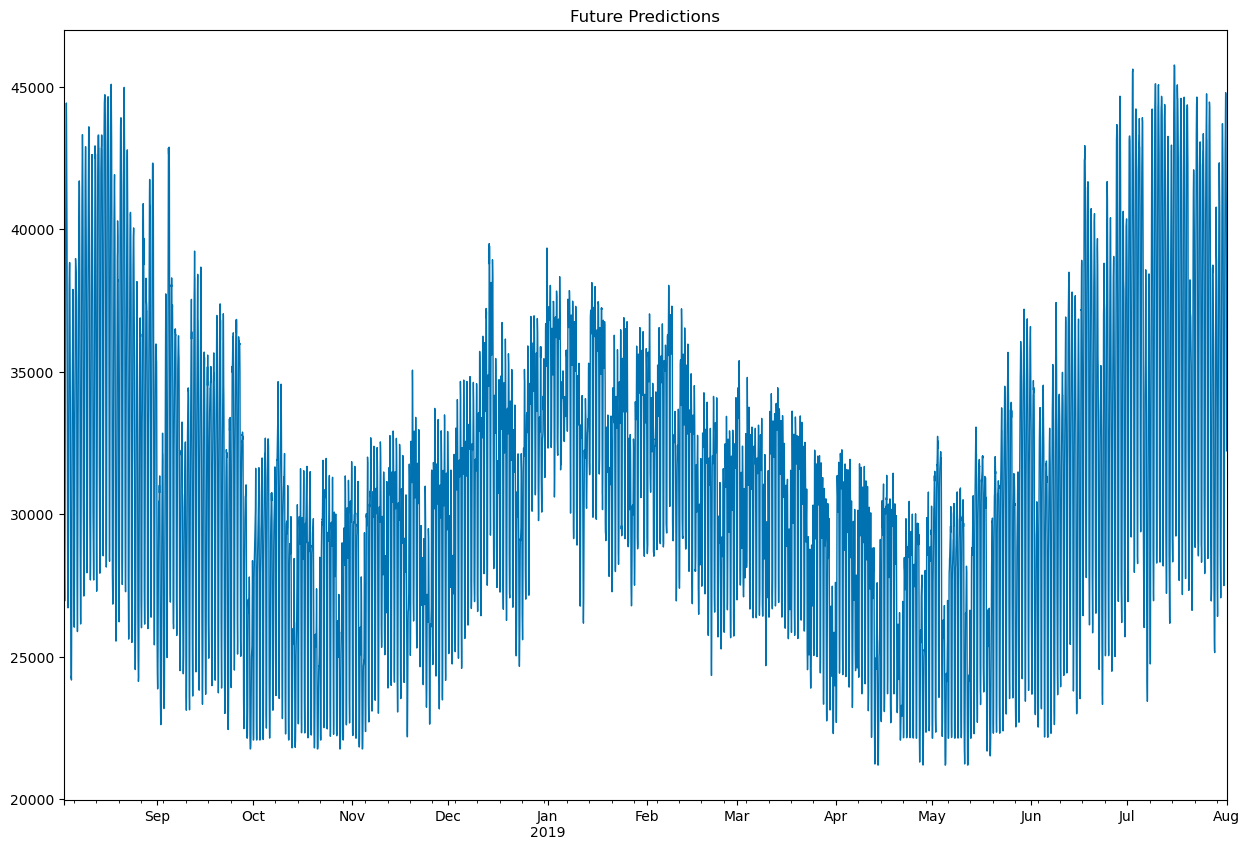

In [87]:
future_features['preds'].plot(figsize=(15,10), 
                              ms=1, 
                              lw=1, 
                              title='Future Predictions');

# Saving the Model

In [91]:
# Save model
reg.save_model('ts_xgb_model.json')

In [93]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('ts_xgb_model.json')

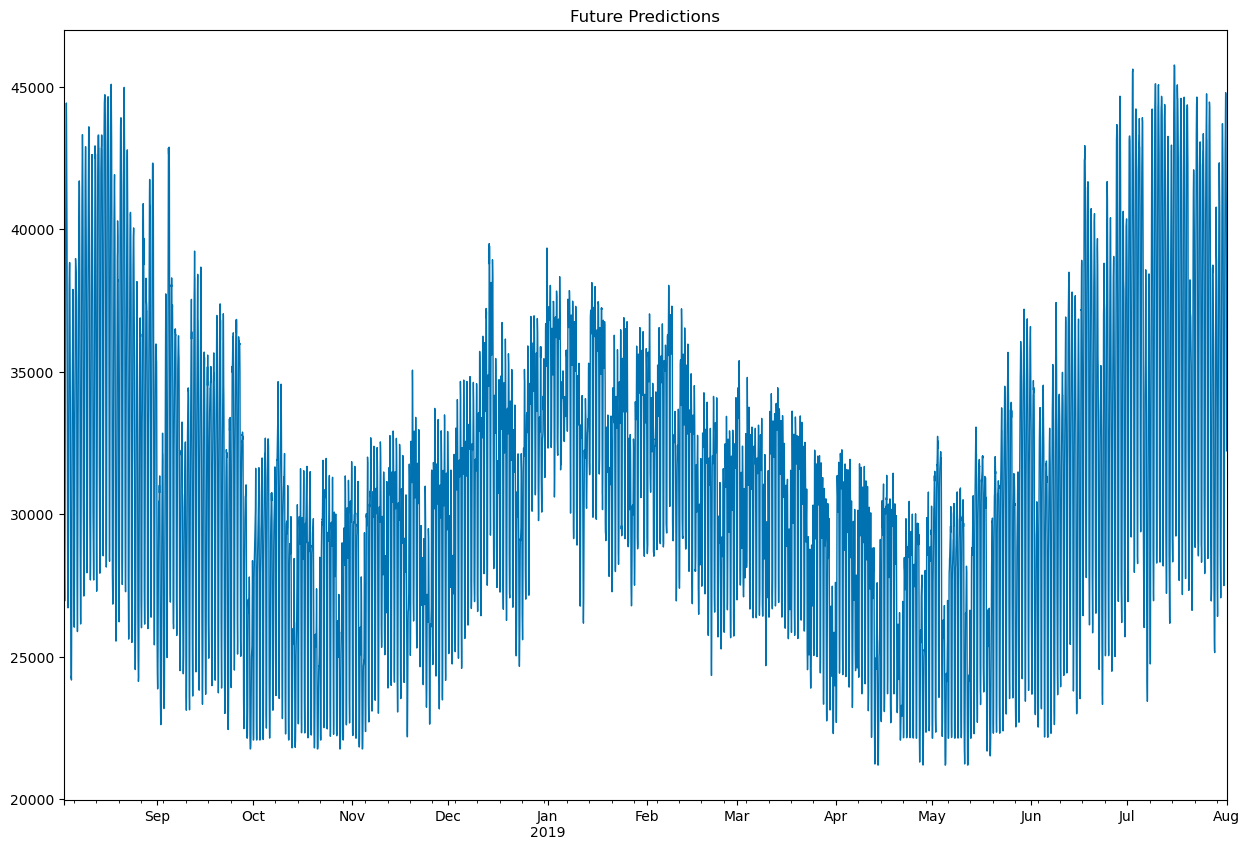

In [95]:
future_features['preds'] = reg.predict(future_features[FEATURES])
future_features['preds'].plot(figsize=(15,10), 
                              ms=1, 
                              lw=1, 
                              title='Future Predictions');